# Τρίτη Εργασία
## Ανατομία του Σθένους στο Spotify
---
> Αλέξανδρος Πετρίδης <br/>
> al1998petridis@gmail.com

### Εγκατάσταση βιβλιοθηκών για το συγκεκριμένο jupyter notebook 

In [10]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Εισαγωγή χρήσιμων βιβλιοθηκών

In [11]:
import glob
from datetime import datetime
import re
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn import tree
from io import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from keras import layers

### Είσοδος στο Spotify API ()
Μπορεί να γίνει είσοδος στο Spotify API είτε με το αρχείο `spotify_config.py`, το οποίο δεν περιέχετε στα αρχεία που ανέβηκαν, τρέχοντας το πρώτο παράθυρο, είτε βάζοντας τα credentials σαν είσοδο στο συγκεκριμένο notebook τρέχοντας το δεύτερο.

In [12]:
# from spotify_config import config

# client_credentials_manager = SpotifyClientCredentials(config['client_id'],
#                                                       config['client_secret'])
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [15]:
client_id = input("Please give client ID")
client_secret = input("Please enter your client Secret")

client_credentials_manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Εισαγωγή δεδομένων

Ο φάκελος `charts.zip` έχει αποσυμπιεστεί στον φάκελο `Charts`, ο οποίος δεν περιέχεται στο παρόν `zip`, λόγω των οδηγιών που δόθηκαν.

In [16]:
# Read data from files
header = 0
dfs = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('/')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)
all_charts = pd.concat(dfs)

# Features of each song from spotify
features = {}
all_track_ids = list(all_charts['song_id'].unique())
start = 0
num_tracks = 100
while start < len(all_track_ids):
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

tracks = pd.DataFrame.from_dict(features, orient='index')
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
del tracks['type'], tracks['uri'], tracks['track_href'], tracks['analysis_url']

# Train data
x_train = tracks.copy()
x_train.set_index('song_id', inplace=True)
y_train = pd.Series(x_train['valence'], name='valence')
x_train = x_train[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms','time_signature']]

# Test data
with open('spotify_ids.txt') as f:
    lines = f.readlines()
for line in range(len(lines)):
    lines[line] = lines[line].replace('\n','')

features_test = {}
test_track_ids = lines
start = 0
num_tracks = 100
while start < len(test_track_ids):
    tracks_batch_test = test_track_ids[start:start+num_tracks]
    features_batch_test = sp.audio_features(tracks_batch_test)
    features_test.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch_test, features_batch_test) })
    start += num_tracks

tracks_test = pd.DataFrame.from_dict(features_test, orient='index')
tracks_test = tracks_test.reset_index(drop=True).rename(columns={'id' : 'song_id'})

x_test = tracks_test.copy()
x_test.set_index('song_id', inplace=True)
y_test = pd.Series(x_test['valence'], name='valence')
x_test = x_test[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms','time_signature']]

* Διαγραφηκαν οι στήλες `type`, `uri`, `track_ref`, `analysis_url` των δεδομένων καθώς δεν θα ήταν χρήσιμα για την εκπαίδευση κάποιου μοντέλου μηχανικής μάθησης

#### Μείωση διαστάσεων με PCA
Δεδομένου ότι η PCA χρησιμοποιεί τη διακύμανση είναι μέθοδος που επιδέχεται (ή χρειάζεται) κανονικοποίηση στα δεδομένα.</br>
Όμως σύμφωνα με την παρακάτω ανάλυση δεν αποτυπώνεται μεγάλο μέρος της πληροφορίας όταν μειώνονται οι διαστάσεις των δεδομένων.</br>
<b>Γι'αυτό το λόγο δε θα γίνει μείωση διαστασιμότητας των δεδομένων</b>

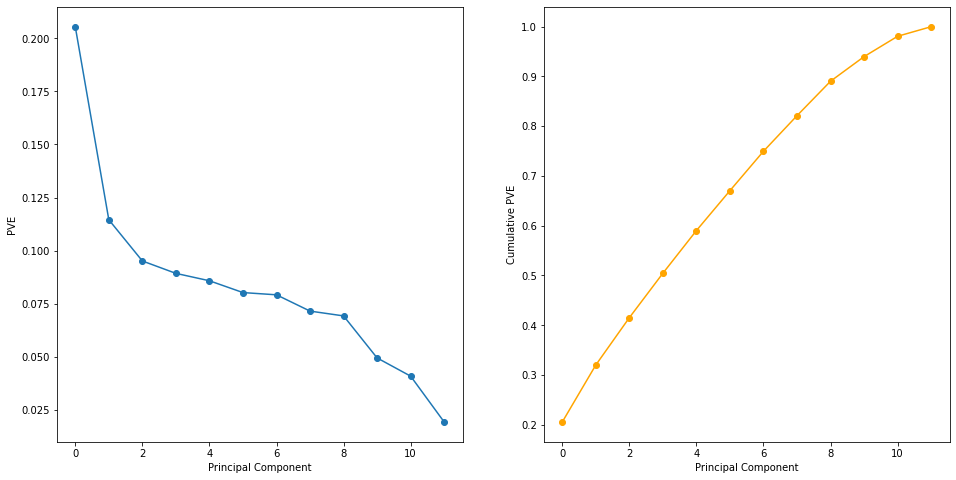

In [17]:
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x_test)
pca = PCA(n_components=12)
pca.fit(x_scaled)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('PVE')
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange')
plt.xlabel('Principal Component')
_ = plt.ylabel('Cumulative PVE')

### Πρόβλεψη Σθένους άνευ Νευρωνικών Δικτύων

#### Μέθοδος 1
Γραμμική παλινδρόμηση

In [18]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)
y_pred1 = regressor.predict(x_test) 
mse1 = mean_absolute_error(y_test, y_pred1)
print(f"Linear regression has Mean Absolute Error = {mse1}")

Linear regression has Mean Absolute Error = 0.16042524564362148


#### Μέθοδος 2
Δένδρα αποφάσεων

In [19]:
# Search for max depth of the tree with GridSearch
parameters = [
  {'max_depth': list(range(1, 12))}
]

cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)
clf = clf.fit(x_train, y_train)
y_pred2 = clf.predict(x_test)
mse2 = mean_absolute_error(y_test, y_pred2)

print(f"Decision Tree with max depth {clf.best_params_['max_depth']} has Mean Absolute Error = {mse2}")

Decision Tree with max depth 6 has Mean Absolute Error = 0.16367630538795902


#### Μέθοδος 3
Τυχαία Δάση

In [20]:
forest = RandomForestRegressor(n_estimators=50, n_jobs=-1)
forest.fit(x_train, y_train)
y_pred3 = forest.predict(x_test)
mse3 = mean_absolute_error(y_test, y_pred3)
print(f"Random Forest has Mean Absolute Error = {mse3}")

Random Forest has Mean Absolute Error = 0.13937175674125069


#### Μέθοδος 4
Ακραίως στοχαστικά δάση

In [21]:
extra_forest = ExtraTreesRegressor(n_estimators=50, n_jobs=-1)
extra_forest.fit(x_train, y_train)
y_pred4 = extra_forest.predict(x_test)
mse4 = mean_absolute_error(y_test, y_pred4)
print(f"Extremely Randomized Trees has Mean Absolute Error = {mse4}")

Extremely Randomized Trees has Mean Absolute Error = 0.1329623580034424


#### Μέθοδος 5
AdaBoost

In [22]:
ada_boost_rgr = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=50)
ada_boost_rgr.fit(x_train, y_train)
y_pred5 = ada_boost_rgr.predict(x_test)
mse5 = mean_absolute_error(y_test, y_pred5)
print(f"AdaBoost has Mean Absolute Error = {mse5}")

AdaBoost has Mean Absolute Error = 0.13105688468158347


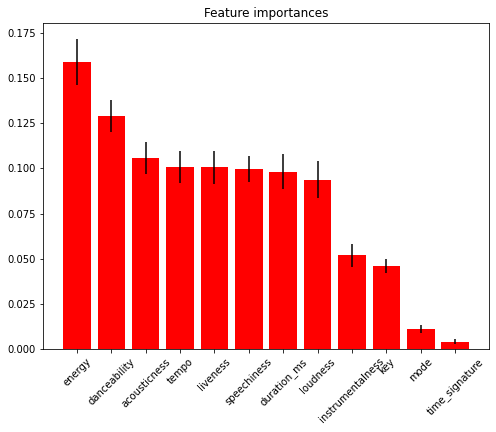

In [23]:
# Feature Importance
importances = ada_boost_rgr.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in ada_boost_rgr.estimators_], axis=0)

plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(x_train.columns)), importances[indices],
        tick_label=[x_train.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=45)

* Παρατηρείται πως αν εκτελεστούν τα παραπάνω μοντέλα πολλές φορές το Μέσο Τετραγωνικό Σφάλμα των Μοντέλων 3-4-5 είναι κάθε φορά καλύτερο από τα Μοντέλα 1-2.</br>
* Ακόμα από την σημαντικότητα των χαρακτηριστικών παρατηρείται ότι τα χαρακτηριστικά `time_signature` και `mode` δεν παρέχουν χρήσιμη πληροφορία.


### Πρόβλεψη Σθένους με Νευρωνικά Δίκτυα

#### Κανονικοποίηση Δεδομένων

In [24]:
# Normalize data
standard_scaler = StandardScaler()
x_train_scaled = pd.DataFrame(standard_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(standard_scaler.transform(x_test), columns = x_test.columns)

#### 1ο Μοντέλο Νευρωνικών Δικτύων
* Στο πρώτο μοντέλο δοκιμάστηκαν οι βελτιστοποιητές `Adam`, `RMSProp` και `SGD` με `learning_rate = 0.001, 0.01 και 0.1`. Επιλεχθηκε ο `SGD` με `learning_rate = 0.01`
* Oι συνερτήσεις ενεργοποίησης `tanh` και `relu` δεν είχαν κάποια διαφορά στο Μέσο τετραγωνικό σφάλμα στο σετ επαλήθευσης.
* Ακόμα δοκιμάστηκαν 16, 32, 64, 128 και 256 νευρώνες για το επίπεδο του νευρωνικού, όμως υπήρχαν φαινόμενα υπερπροσαρμογής όσο αυξανόταν ο αριθμός των νευρώνων, ο βέλτιστος αριθμός νευρώνων ήταν το 32.
* Χρόνος εκπαίδευσης &asymp; 0.5 minutes

2022-05-02 21:04:27.674885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 21:04:27.675317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 21:04:27.675381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-02 21:04:27.675437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-02 21:04:27.675491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Mean Absolute Error of Neural Network 1: 0.15526332446359314


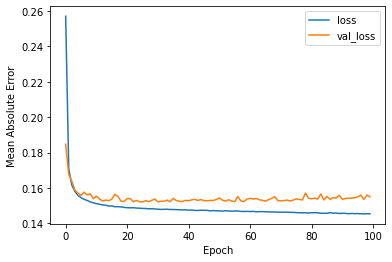

In [25]:
model = keras.models.Sequential()
model.add(layers.Dense(32, input_shape=(12,), activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mae', metrics=['mae']) 

history = model.fit(x_train_scaled, y_train, epochs=100, verbose=False, validation_split=0.25, batch_size=32) 
y_pred_nn = model.predict(x_test_scaled)
print(f"Mean Absolute Error of Neural Network 1: {mean_absolute_error(y_test,y_pred_nn)}")

# Plot MSE    
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()


#### 2ο Μοντέλο Νευρωνικών Δικτύων
* Ελαφρώς καλύτερη αλλα δίχως μεγάλη διαφορά μετρικής από το 1ο μοντέλο
* Υπερπροσαρμογή στα δεδομένα εκπαίδευσης
* Χρόνος εκπαίδευσης &asymp; 0.8 minutes

Mean Absolute Error of Neural Network 2: 0.15904367925126664


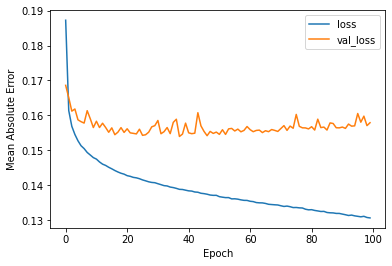

In [26]:
model2 = keras.models.Sequential()
model2.add(layers.Dense(32, input_shape=(12,), activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))
model2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mae', metrics=['mae']) 

history2 = model2.fit(x_train_scaled, y_train, epochs=100, verbose=False, validation_split=0.25, batch_size=32) 
y_pred_nn2 = model2.predict(x_test_scaled)
print(f"Mean Absolute Error of Neural Network 2: {mean_absolute_error(y_test,y_pred_nn2)}")

# Plot MSE    
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()


#### 3ο Μοντέλο Νευρωνικών Δικτύων
* Βελτίωση του φαινομένου υπερπροσαρμογής
* Δεν υπήρξε βελτίωση της μετρικής των Μέσων Τετραγωνικών Σφαλμάτων
* Χρόνος εκπαίδευσης &asymp; 0.8 minutes

Mean Absolute Error of Neural Network 3: 0.16058804141348693


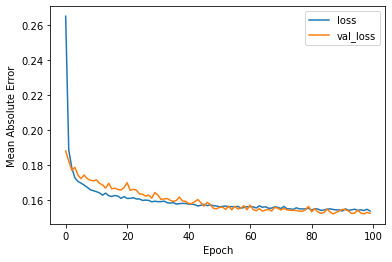

In [27]:
model3 = keras.models.Sequential()
model3.add(layers.Dense(32, input_shape=(12,), activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='relu'))
model3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mae', metrics=['mae']) 

history3 = model3.fit(x_train_scaled, y_train, epochs=100, verbose=False, validation_split=0.25, batch_size=32) 
y_pred_nn3 = model3.predict(x_test_scaled)
print(f"Mean Absolute Error of Neural Network 3: {mean_absolute_error(y_test,y_pred_nn3)}")

# Plot MSE    
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

### Αξιολόγηση μοντέλων

Στον παρακάτω πίνακα φαίνεται η μετρική Μέσου Απόλυτου Σφάλματος για όλα τα μοντέλα μηχανικής μάθησης και νευρωνικών δικτύων. Το συγκεκριμένο πρόβλημα λύθηκε καλύτερα με το μοντέλο AdaBoost. Ακόμα γενικότερα τα μοντέλα δένδρων μηχανικής μάθησης τα πήγαν καλύτερα από τα νευρωνικά δίκτυα.

<table>
    <tr>
        <th colspan="6"> Non-Neural Networks</th>
    </tr>
    <tr>
        <th></th>
        <th>Linear Regression</th>
        <th>Decision Tree</th>
        <th>Random Forest</th>
        <th>Extra Stochastic Trees</th>
        <th>AdaBoost</th> 
    </tr>
    <tr>
        <th>Mean Absolute Error</th>
        <td>0.16042524564362148</td>
        <td>0.16367630538795902</td>
        <td>0.13937175674125069</td>
        <td>0.1329623580034424</td>
        <td>0.13105688468158347</td>
    </tr>
</table>


<table>
    <tr>
        <th colspan="4"> Neural Networks</th>
    </tr>
    <tr>
        <th></th>
        <th>1st Neural Network</th>
        <th>2nd Neural Network</th>
        <th>3rd Neural Network</th>  
    </tr>
    <tr>
        <th>Mean Absolute Error</th>
        <td>0.15526332446359314</td>
        <td>0.15904367925126664</td>
        <td>0.16058804141348693</td>
    </tr>
</table>